In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyter_dash import JupyterDash
from dash import dcc, html
import plotly.graph_objs as go
from prophet import Prophet
import sqlite3

# CSV dosyasını yükle
df = pd.read_csv("/Users/ogulcan/Desktop/Projects/archive-2/FMCG_2022_2024.csv")

In [2]:
# Tarih sütununu datetime yap
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Eksik veri kontrolü
print(df.isnull().sum())

# Eksik satış değerlerini 0 ile doldur
df['units_sold'].fillna(0, inplace=True)

date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64


/var/folders/jl/m9thb3l97_14j8thlylmz5v40000gn/T/ipykernel_54886/1199675343.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['units_sold'].fillna(0, inplace=True)


In [3]:
# Geçici SQL veritabanı oluştur
conn = sqlite3.connect(":memory:")

# DataFrame’i SQL tablosu olarak yükle
df.to_sql("sales", conn, index=False, if_exists='replace')

# SQL sorgusu: Kanal & hafta bazlı satış
query = """
SELECT channel, strftime('%Y-%W', date) as week, SUM(units_sold) as weekly_sales
FROM sales
GROUP BY channel, week
ORDER BY week
"""
weekly_sales = pd.read_sql(query, conn)
print(weekly_sales.head(10))

      channel     week  weekly_sales
0    Discount  2022-03           224
1  E-commerce  2022-03           122
2      Retail  2022-03           103
3    Discount  2022-04           439
4  E-commerce  2022-04           477
5      Retail  2022-04           408
6    Discount  2022-05           438
7  E-commerce  2022-05           503
8      Retail  2022-05           555
9    Discount  2022-06           402


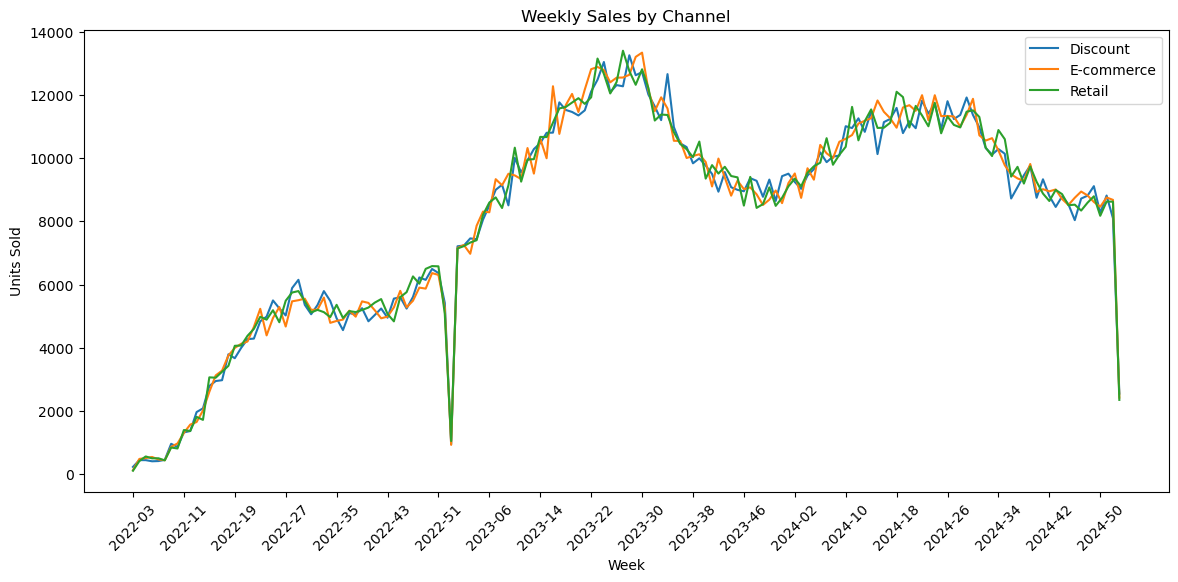

In [4]:
plt.figure(figsize=(14,6))
for channel in weekly_sales['channel'].unique():
    df_channel = weekly_sales[weekly_sales['channel']==channel]
    plt.plot(df_channel['week'], df_channel['weekly_sales'], label=channel)

plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.title('Weekly Sales by Channel')
plt.legend()
plt.xticks(ticks=range(0, len(weekly_sales['week'].unique()), 8),  # her 8 haftada bir göster
           labels=weekly_sales['week'].unique()[::8], rotation=45)
plt.show()

In [5]:
# Retail kanalı örneği
retail_data = weekly_sales[weekly_sales['channel']=='Retail'].copy()

# Year-Week → datetime (haftanın Pazartesi günü)
retail_data['ds'] = pd.to_datetime(retail_data['week'] + '-1', format='%Y-%W-%w')

# Prophet hedef sütunu
retail_data['y'] = retail_data['weekly_sales']

# Prophet için uygun DataFrame
prophet_df = retail_data[['ds','y']]
prophet_df.head()

,ds,y
2,2022-01-17,103
5,2022-01-24,408
8,2022-01-31,555
11,2022-02-07,495
14,2022-02-14,497


In [6]:
# Prophet modeli oluştur
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

# Gelecek 8 hafta için tahmin
future = model.make_future_dataframe(periods=8, freq='W')
forecast = model.predict(future)

forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

10:58:33 - cmdstanpy - INFO - Chain [1] start processing
10:58:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
153,2024-12-23,6965.272631,6044.101899,7795.018321
154,2024-12-30,6756.757851,5944.688474,7661.423015
155,2025-01-05,7167.846288,6350.524691,7963.338238
156,2025-01-12,8170.368126,7341.624044,8990.329117
157,2025-01-19,9000.854450,8188.170327,9851.908859
158,2025-01-26,9269.806845,8433.905071,10067.298312
159,2025-02-02,9127.991814,8251.382481,9993.338206
160,2025-02-09,8981.310386,8080.015564,9853.956920
161,2025-02-16,9049.367760,8222.334529,9919.858139
162,2025-02-23,9242.619003,8418.174062,10100.361823


In [7]:
from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast)
fig.update_layout(
    title='Retail Weekly Sales Forecast (Next 8 Weeks)',
    xaxis_title='Week',
    yaxis_title='Units Sold'
)
fig.show()

   promotion_flag  avg_sales
0               0  17.439900
1               1  34.060574


/var/folders/jl/m9thb3l97_14j8thlylmz5v40000gn/T/ipykernel_54886/1976954966.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




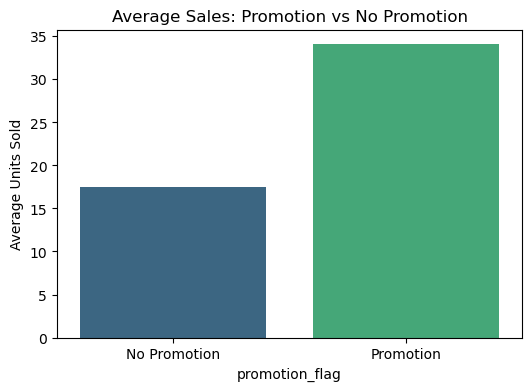

In [8]:
# Promosyon etkisi: promosyonlu vs promosyon olmayan satışlar
promo_query = """
SELECT promotion_flag, AVG(units_sold) as avg_sales
FROM sales
GROUP BY promotion_flag
"""
promo_effect = pd.read_sql(promo_query, conn)
print(promo_effect)

# Görselleştirme
plt.figure(figsize=(6,4))
sns.barplot(x='promotion_flag', y='avg_sales', data=promo_effect, palette='viridis')
plt.xticks([0,1], ['No Promotion','Promotion'])
plt.title('Average Sales: Promotion vs No Promotion')
plt.ylabel('Average Units Sold')
plt.show()

/var/folders/jl/m9thb3l97_14j8thlylmz5v40000gn/T/ipykernel_54886/209099689.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




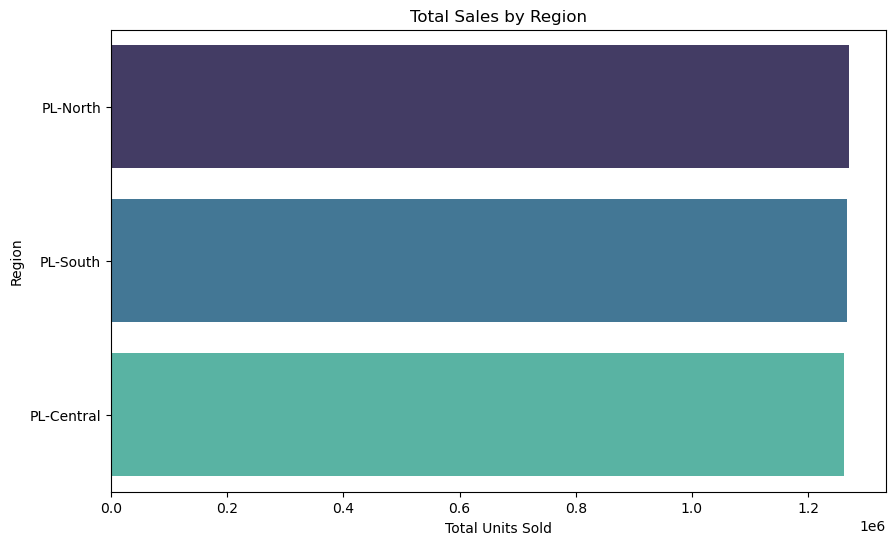

In [9]:
region_query = """
SELECT region, SUM(units_sold) as total_sales
FROM sales
GROUP BY region
ORDER BY total_sales DESC
"""
region_sales = pd.read_sql(region_query, conn)

# Görselleştirme
plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='region', data=region_sales, palette='mako')
plt.title('Total Sales by Region')
plt.xlabel('Total Units Sold')
plt.ylabel('Region')
plt.show()

In [10]:
# Retail promosyonlu veri
retail_data = df[df['channel']=='Retail'].copy()

# Weekly aggregation + promosyon
retail_data = retail_data.groupby([pd.Grouper(key='date', freq='W'), 'promotion_flag'])['units_sold'].sum().reset_index()

# Prophet formatı
retail_data.rename(columns={'date':'ds','units_sold':'y'}, inplace=True)

# Model oluştur
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_regressor('promotion_flag')

# Eğit
model.fit(retail_data)

# Gelecek 8 hafta tahmini (örnek olarak promosyon yok varsayıyoruz)
future = model.make_future_dataframe(periods=8, freq='W')
future['promotion_flag'] = 0

forecast = model.predict(future)

# Görselleştir
fig = plot_plotly(model, forecast)
fig.update_layout(title='Retail Forecast with Promotion Effect')
fig.show()

10:59:37 - cmdstanpy - INFO - Chain [1] start processing
10:59:37 - cmdstanpy - INFO - Chain [1] done processing
